<a href="https://www.kaggle.com/code/shravankumar147/understanding-backpropagation-with-sympy?scriptVersionId=191432243" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import sympy as sp
from sympy import symbols, diff, simplify, preorder_traversal, lambdify
# Function to find all sub-expressions in a given expression
def get_sub_expressions(expression):
    sub_expressions = set()
    for sub_expr in preorder_traversal(expression):
        sub_expressions.add(sub_expr)
    return sub_expressions

# Function to calculate and print derivatives
def print_derivatives(expression, variables, values=None):
    sub_expressions = sorted(get_sub_expressions(expression), key=lambda x: len(str(x)))
    final_derivatives = []
    for var in variables:
        print(f'\nDifferentiating with respect to {var}:')
        seen_expressions = set()

        for sub_expr in sub_expressions:
            if sub_expr in seen_expressions or not var in sub_expr.free_symbols:
                continue
#             print(sub_expr)
            seen_expressions.add(sub_expr)
            derivative = diff(sub_expr, var)

        final_derivative = diff(expression, var)
        if values is not None:
            numeric_derivative = final_derivative.subs(values)
            dy_dvar = f' \n \t  ==>   dy/d{var} = {simplify(final_derivative)} = {numeric_derivative.evalf()}\n'
            print(dy_dvar)
            final_derivatives.append(dy_dvar)
        else:
            dy_dvar = f' \n \t  ==>   dy/d{var} = {simplify(final_derivative)}'
            print(dy_dvar)
            final_derivatives.append(dy_dvar)     
    print(80*"=")
    print(f"Final Derivetives:")    
    for d in final_derivatives:
        print(d)

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    n._op = n._op
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [3]:
import math

In [4]:

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=None,):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
        self.label = label or str(data)
        
    def __repr__(self):
        return f"{self.label} = {self.data}"        

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+', f"({self.label}+{other.label})")

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*', f"({self.label}*{other.label})")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}', f"('**{other})")

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        #t = tanh(self.data) 
        # f(x) = tanh(x) =  2/(1+exp(-2x)) -1
        #                = 2*(1+exp(-2x)**-1) - 1
        
        x = self.data
#         t = 2*(1+math.exp(-2*x)) -1
        t = math.tanh(x)
        out = Value(t, (self,), "tanh", f"tanh({self.label})")
        
        
        
        def _backward():
            #d(tanh(x)/d(x) = 1 - (tanh(x))**2
            self.grad += (1 - (math.tanh(self.data)**2)) * out.grad
            
        out._backward = _backward
        
        return out
        

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU', f"(relu{self.label})")

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

# Initiate the Expression 

In [5]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1#; x1w1.label = 'x1*w1'
x2w2 = x2*w2#; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2#; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b#; n.label = 'n'
o = n.tanh()#; o.label = 'o'
o

Value(data=0.7071067811865477, grad=0)

# Visualize DAG

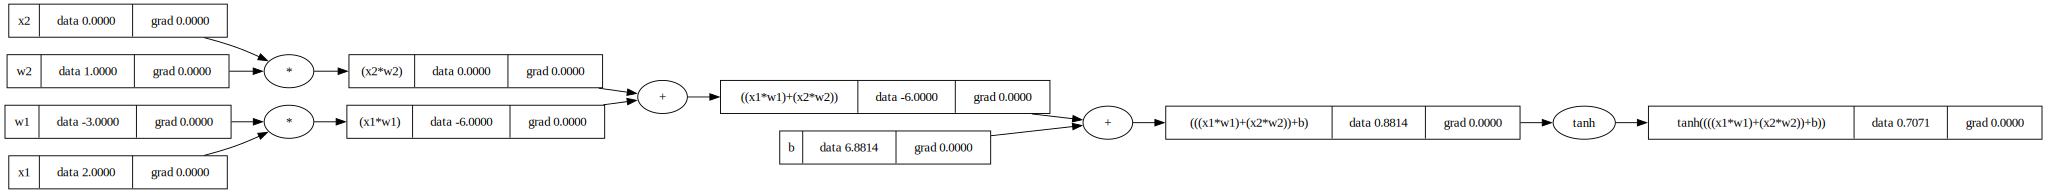

In [6]:
draw_dot(o)

In [7]:
o.backward()

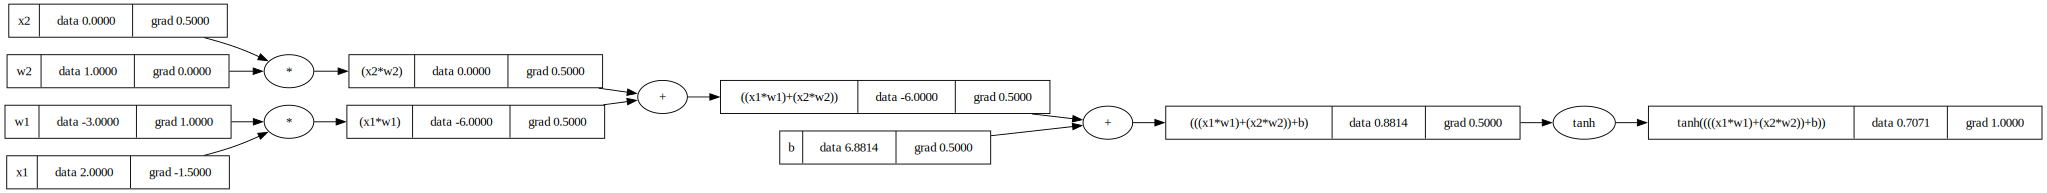

In [8]:
draw_dot(o)

In [9]:
# Create the expression in SymPy
expression_str = o.label
expression = sp.simplify(expression_str.replace('^', '**'))  # Convert to sympy compatible format

# Extract variables from the expression
variables = list(expression.free_symbols)
variables.sort(key=lambda var: str(var))
print(variables)

[b, w1, w2, x1, x2]


In [10]:
# Create a dictionary mapping sympy symbols to real values
values = {
    sp.symbols('x1'): x1.data,
    sp.symbols('x2'): x2.data,
    sp.symbols('w1'): w1.data,
    sp.symbols('w2'): w2.data,
    sp.symbols('b'): b.data,
}

# Print the dictionary of values
print("Dictionary of sympy symbols and their values:")
for var, val in values.items():
    print(f"{var} = {val}")

Dictionary of sympy symbols and their values:
x1 = 2.0
x2 = 0.0
w1 = -3.0
w2 = 1.0
b = 6.881373587019543


In [11]:
expression, values

(tanh(b + w1*x1 + w2*x2),
 {x1: 2.0, x2: 0.0, w1: -3.0, w2: 1.0, b: 6.881373587019543})

In [12]:
# Evaluate the expression with the given values
expression_value = expression.evalf(subs=values)

# Print the evaluated expression value
print(f"\nEvaluated expression value: {expression_value}")


Evaluated expression value: 0.707106781186548


In [13]:
# Print derivatives for each variable
print_derivatives(expression, variables, values)


Differentiating with respect to b:
 
 	  ==>   dy/db = 1 - tanh(b + w1*x1 + w2*x2)**2 = 0.500000000000000


Differentiating with respect to w1:
 
 	  ==>   dy/dw1 = -x1*tanh(b + w1*x1 + w2*x2)**2 + x1 = 1.00000000000000


Differentiating with respect to w2:
 
 	  ==>   dy/dw2 = -x2*tanh(b + w1*x1 + w2*x2)**2 + x2 = 0


Differentiating with respect to x1:
 
 	  ==>   dy/dx1 = -w1*tanh(b + w1*x1 + w2*x2)**2 + w1 = -1.50000000000000


Differentiating with respect to x2:
 
 	  ==>   dy/dx2 = -w2*tanh(b + w1*x1 + w2*x2)**2 + w2 = 0.500000000000000

Final Derivetives:
 
 	  ==>   dy/db = 1 - tanh(b + w1*x1 + w2*x2)**2 = 0.500000000000000

 
 	  ==>   dy/dw1 = -x1*tanh(b + w1*x1 + w2*x2)**2 + x1 = 1.00000000000000

 
 	  ==>   dy/dw2 = -x2*tanh(b + w1*x1 + w2*x2)**2 + x2 = 0

 
 	  ==>   dy/dx1 = -w1*tanh(b + w1*x1 + w2*x2)**2 + w1 = -1.50000000000000

 
 	  ==>   dy/dx2 = -w2*tanh(b + w1*x1 + w2*x2)**2 + w2 = 0.500000000000000



# Ground Truth with torch

In [14]:
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
